# Data exploration

## Imports

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
import random

IMAGES_RGB_PATH = "data/AOI_3_Paris_Train/RGB-PanSharpen/"
COMMON_NAME_RGB = "RGB-PanSharpen_AOI_3_Paris_img"

GEOJSONS_PATH = "data/AOI_3_Paris_Train/geojson/buildings/"
COMMON_NAME_GEOJSONS = "buildings_AOI_3_Paris_img"

## Useful functions

In [2]:
def get_random_image():
    images_filenames = os.listdir(IMAGES_RGB_PATH)
    random_image_path = IMAGES_RGB_PATH + random.choice(images_filenames)
    index_image = random_image_path[len(COMMON_NAME_RGB):-4]
    geojson_path = GEOJSONS_PATH + COMMON_NAME_GEOJSONS + index_image + ".geojson"
    return random_image_path, geojson_path
    

def gdal_to_rgb(ds):
    img = ds.ReadAsArray()
    img = np.transpose(img, (1, 2, 0))
    img = img.astype(np.float32)

    min_vals = np.min(img, axis=(0, 1))
    max_vals = np.max(img, axis=(0, 1))

    normalized_image = (img - min_vals) / (max_vals - min_vals)

    return (normalized_image * 255).astype(np.uint8)

def display_image(image_path):
    ds = gdal.Open(image_path)
    img = gdal_to_rgb(ds)
    plt.imshow(img)
    plt.axis('off')

## Dataset exploring

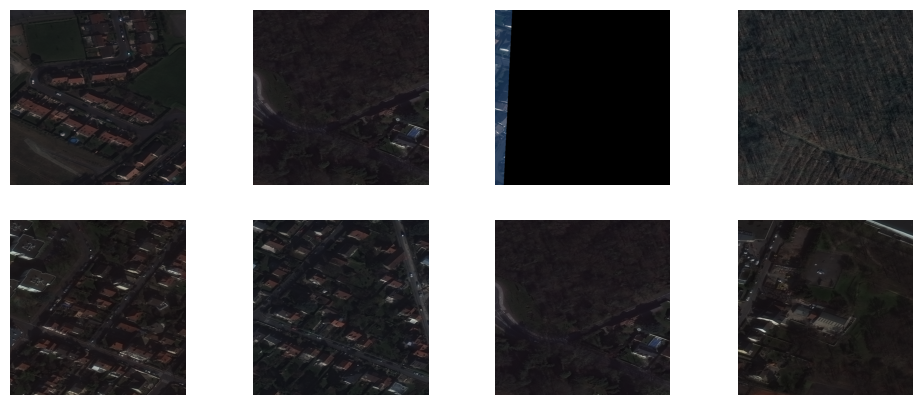

In [16]:
plt.figure(figsize=(12, 5))
grid_spec = plt.GridSpec(2, 4, width_ratios=[1, 1, 1, 1])

for i in range(8):
    image_path = get_random_image()[0]
    plt.subplot(grid_spec[i])
    display_image(image_path)